<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/Image_Classification_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install keras==2.15.0
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires keras>=3.5.0, but you have keras 2.15.0 which is incompatible.


In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import accuracy_score


In [3]:
# Load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()


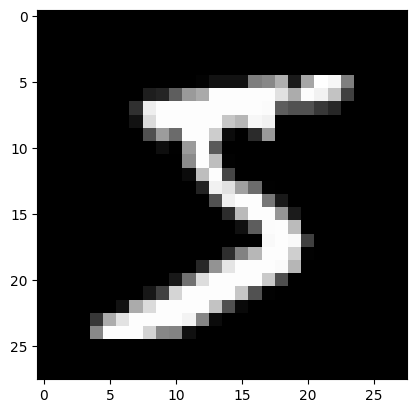

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X_train[0], cmap="gray", interpolation="nearest")

In [5]:
#print(X_train[0])

In [6]:
X_train.shape

(60000, 28, 28)

Vision Transformers expect 3D input (e.g., 224×224×3). MNIST images are 28×28 grayscale.

In [7]:
''' uses all RAM and crashes
X_train = tf.image.resize(tf.expand_dims(X_train, -1), [224, 224])
X_test = tf.image.resize(tf.expand_dims(X_test, -1), [224, 224])
X_train = tf.repeat(X_train, 3, axis=-1)  # Convert grayscale to 3-channel RGB
X_test = tf.repeat(X_test, 3, axis=-1)
'''

' uses all RAM and crashes\nX_train = tf.image.resize(tf.expand_dims(X_train, -1), [224, 224])\nX_test = tf.image.resize(tf.expand_dims(X_test, -1), [224, 224])\nX_train = tf.repeat(X_train, 3, axis=-1)  # Convert grayscale to 3-channel RGB\nX_test = tf.repeat(X_test, 3, axis=-1)\n'

In [8]:
def preprocess(image, label):
    image = tf.expand_dims(image, -1)  # Add channel dimension
    image = tf.image.resize(image, [224, 224])
    image = tf.image.grayscale_to_rgb(image)  # Converts to 3 channels
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, 10)

batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(1024) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)


In [9]:
X_test

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [10]:
# Convert labels to categorical format
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
#y_train

In [11]:
from sklearn.model_selection import train_test_split

# Split into train and test sets (80% train, 20% test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
# Make sure X_train is 4D (i.e., has a channel dimension)
if X_train.ndim == 3:
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]


In [13]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_train)


In [14]:
from transformers import ViTFeatureExtractor, TFViTForImageClassification
from transformers import DefaultDataCollator

model = TFViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=10)


/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


RuntimeError: Failed to import transformers.models.vit.modeling_tf_vit because of the following error (look up to see its traceback):
module 'tensorflow._api.v2.compat.v2.__internal__' has no attribute 'register_load_context_function'

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_mnist_model.h5", save_best_only=True)

In [ ]:
# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=5,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)

In [ ]:
plt.figure(figsize=(10, 6))
epochs_range = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs_range, history.history['accuracy'], label="Training accuracy", color='blue')
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Training vs Validation accuracy")
plt.legend()
plt.show()

In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class index with the highest probability
y_test_classes = np.argmax(y_test, axis=1)  # Get the class index with the highest probability

In [ ]:
accuracy_score=(accuracy_score(y_test_classes, y_pred_classes))
print(f"Test Accuracy: {accuracy_score:.4f}")